In [1]:
import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import matplotlib.pyplot as plt 
from PIL import Image , ImageDraw 
from sklearn.preprocessing import * 
import time 
import ast 
import os 
import keras 
import tensorflow as tf 
from keras import models, layers 
from keras import Input 
from keras.models import Model, load_model 
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers, initializers, regularizers, metrics 
from keras.callbacks import ModelCheckpoint, EarlyStopping 
from keras.layers import BatchNormalization, Conv2D, Activation , AveragePooling2D , Input ,Dropout 
from keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add, Flatten 
from keras.models import Sequential 
from keras.metrics import top_k_categorical_accuracy 
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping 
from keras.applications import ResNet50, vgg19,mobilenet_v2,InceptionV3 , InceptionResNetV2,DenseNet169 
from tqdm import tqdm 
import cv2

In [2]:
path = 'C:/Users/sdf80/Desktop/fruit_dataset2/Bad_Normal/Side/Mix/'

filename = os.listdir(path)
datalist = pd.DataFrame(data=[], columns=['label','img'])

label = []
img = []

for file in tqdm(filename):
    label.append(file.split('.')[0])
    img.append(file)
    
datalist['label'] = label
datalist['img'] = img

datalist.head()

100%|████████████████████████████████████████████████████████████████████████████| 422/422 [00:00<00:00, 923797.65it/s]


,label,img
0,SideBad,SideBad.0.jpg
1,SideBad,SideBad.1.jpg
2,SideBad,SideBad.10.jpg
3,SideBad,SideBad.100.jpg
4,SideBad,SideBad.101.jpg


No handles with labels found to put in legend.


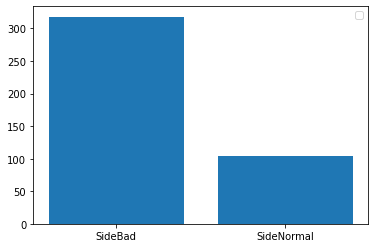

In [3]:
catnum = 0
dognum = 0

for i in datalist['label']:
    if i == 'SideBad':
        catnum += 1
    if i == 'SideNormal':
        dognum += 1

#Normal 데이터 갯수 Bad와 비슷하게 맞추기.
plt.bar([1,2],[catnum, dognum],tick_label=['SideBad','SideNormal']) 
plt.legend()

In [4]:
def preprocessing(path) :
    X = []
    Y = []
    class_label = []
    class_num = 2
    
    for num in tqdm(range(len(datalist['img']))) :
        img = cv2.imread(path+datalist['img'][num])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(160,160))
        
        if datalist['label'][num] == 'SideBad': 
            X.append(img) 
            Y.append(0) 
        else : 
            X.append(img) 
            Y.append(1)

    tmpx = np.array(X) 

    Y = np.array([[i] for i in Y]) 
    enc = OneHotEncoder(categories='auto') 
    enc.fit(Y) 
    tmpy = enc.transform(Y).toarray() 

    del X 
    del Y #RAM메모리 절약을 위해 사용하지 않는 변수 삭제
    return tmpx , tmpy , class_label , class_num


tmpx, tmpy, class_label, class_num = preprocessing(path) 
#파일이름이 담긴 배열 
print(tmpx.shape, tmpy.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 422/422 [00:01<00:00, 307.59it/s]

(422, 160, 160, 3) (422, 2)


array([1., 0.])

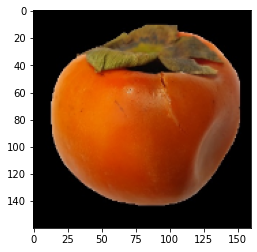

In [5]:
img = cv2.imread(path+datalist['img'][1])
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(tmpx[40])
tmpy[40]

In [6]:
from sklearn.model_selection import train_test_split 
X_train, X_val, Y_train, Y_val = train_test_split(tmpx,tmpy, test_size = 0.2,random_state = 1) 
del tmpx 
del tmpy #RAM메모리 절약을 위해 사용하지 않는 변수 삭제 

print(X_train.shape,X_val.shape,Y_train.shape,Y_val.shape)

(337, 160, 160, 3) (85, 160, 160, 3) (337, 2) (85, 2)


In [53]:
nb_train_samples = len(X_train) 
nb_validation_samples = len(X_val) 
batch_size = 4

train_datagen = ImageDataGenerator( 
    rescale=1. / 255, rotation_range=360,
    horizontal_flip=True, vertical_flip=True) 

val_datagen = ImageDataGenerator( 
    rescale=1. / 255, rotation_range=360,
    horizontal_flip=True, vertical_flip=True) 

train_generator = train_datagen.flow(np.array(X_train), Y_train, batch_size=batch_size) 
validation_generator = val_datagen.flow(np.array(X_val), Y_val, batch_size=batch_size)

In [48]:
tf.random.set_seed(2)

In [36]:
model = Sequential()

model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(160,160, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(16,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 158, 158, 8)       224       
_________________________________________________________________
batch_normalization_12 (Batc (None, 158, 158, 8)       32        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 79, 79, 8)         0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 79, 79, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 77, 77, 16)        1168      
_________________________________________________________________
batch_normalization_13 (Batc (None, 77, 77, 16)        64        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 38, 38, 16)       

In [55]:
learning_rate = 0.001


model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=3,
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    )

Epoch 1/3
84/84 [==============================] - 12s 143ms/step - loss: 0.4985 - accuracy: 0.7868
Epoch 2/3
84/84 [==============================] - 12s 142ms/step - loss: 0.4986 - accuracy: 0.7508
Epoch 3/3
84/84 [==============================] - 12s 142ms/step - loss: 0.4402 - accuracy: 0.7988


In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

KeyError: 'val_accuracy'

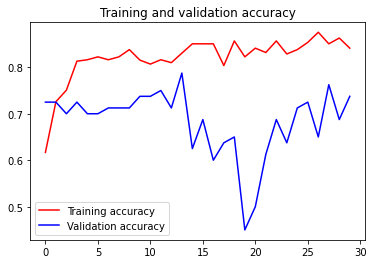

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [57]:
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import RMSprop

pre_trained_model = InceptionV3(input_shape=(160, 160, 3),
                              include_top=False,
                              weights=None)
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(2, activation='sigmoid')(x)

model2 = Model(pre_trained_model.input, x)

model2.compile(optimizer=RMSprop(lr=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 79, 79, 32)   96          conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 79, 79, 32)   0           batch_normalization_16[0][0]     
_______________________________________________________________________________________

In [58]:
history = model2.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=30,
    validation_data=validation_generator, 
    validation_steps=nb_validation_samples // batch_size,
    )

Epoch 1/30
84/84 [==============================] - 111s 1s/step - loss: 9.6352 - accuracy: 0.6667 - val_loss: 0.5989 - val_accuracy: 0.7143
Epoch 2/30
84/84 [==============================] - 110s 1s/step - loss: 2.8314 - accuracy: 0.6577 - val_loss: 15.1363 - val_accuracy: 0.7143
Epoch 3/30
84/84 [==============================] - 110s 1s/step - loss: 0.8882 - accuracy: 0.7327 - val_loss: 7.1948 - val_accuracy: 0.7143
Epoch 4/30
84/84 [==============================] - 111s 1s/step - loss: 0.7091 - accuracy: 0.7087 - val_loss: 0.6547 - val_accuracy: 0.7262
Epoch 5/30
84/84 [==============================] - 109s 1s/step - loss: 0.5760 - accuracy: 0.7658 - val_loss: 1.5609 - val_accuracy: 0.7143
Epoch 6/30
84/84 [==============================] - 112s 1s/step - loss: 0.5579 - accuracy: 0.7267 - val_loss: 160.4752 - val_accuracy: 0.7262
Epoch 7/30
84/84 [==============================] - 109s 1s/step - loss: 0.5792 - accuracy: 0.7417 - val_loss: 10.1972 - val_accuracy: 0.7262
Epoch 8/3

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

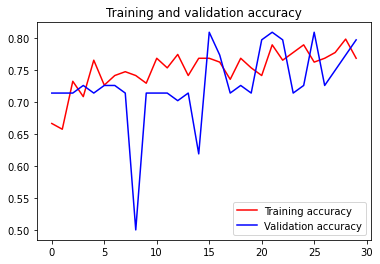

<Figure size 432x288 with 0 Axes>

In [72]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [73]:
Y_Predict= model2.predict(X_val/255)

In [78]:
Y_predict = []
for a in Y_Predict:
    Y_predict.append(np.argmax(a))

In [ ]:
Y_true = []
for a in Y_val:
    Y_true.append(np.argmax(a))

In [87]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

cm = confusion_matrix(y_true=Y_true, y_pred=Y_predict)
cm

array([[50, 11],
       [ 6, 18]], dtype=int64)

In [90]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[50 11]
 [ 6 18]]


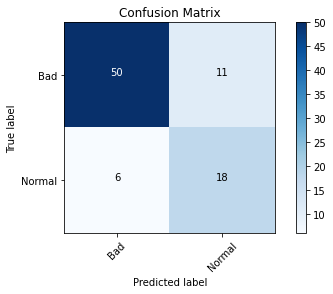

In [92]:
cm_plot_labels = ['Bad','Normal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [104]:
count = 0
different = []
for i, j in zip(Y_predict, Y_true):
    if i != j :
        different.append([count,{"predict":i}, {"True":j}])
    count+=1

In [105]:
#1: Bad, 0:Normal
different

[[1, {'predict': 1}, {'True': 0}],
 [17, {'predict': 1}, {'True': 0}],
 [21, {'predict': 0}, {'True': 1}],
 [24, {'predict': 1}, {'True': 0}],
 [31, {'predict': 1}, {'True': 0}],
 [42, {'predict': 0}, {'True': 1}],
 [47, {'predict': 1}, {'True': 0}],
 [48, {'predict': 0}, {'True': 1}],
 [57, {'predict': 1}, {'True': 0}],
 [58, {'predict': 1}, {'True': 0}],
 [59, {'predict': 0}, {'True': 1}],
 [67, {'predict': 1}, {'True': 0}],
 [70, {'predict': 1}, {'True': 0}],
 [71, {'predict': 1}, {'True': 0}],
 [77, {'predict': 1}, {'True': 0}],
 [78, {'predict': 0}, {'True': 1}],
 [84, {'predict': 0}, {'True': 1}]]

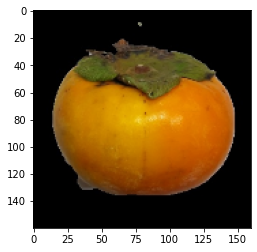

In [112]:
img = cv2.cvtColor(X_val[1],cv2.COLOR_BGR2RGB)
plt.imshow(X_val[78])
#X_val[1]

In [113]:
'''
iterations = 50
images = []
    
for i in different:
    #img,label = validation_generator.next()
    n_img = len(label)
    base = cv2.cvtColor(X_val[i], cv2.COLOR_RGB2BGR)  # keras는 RGB, openCV는 BGR이라 변경함
    for idx in range(n_img - 1):
        img2 = cv2.cvtColor(img[idx + 1], cv2.COLOR_RGB2BGR)
        base = np.hstack((base, img2))
    images.append(base)
img = images[0]
for idx in range(len(images) - 1):
    img = np.vstack((img, images[idx + 1]))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
fig = plt.figure(figsize=(30,10))
plt.imshow(img)
print(np.shape(images))
'''

'\niterations = 50\nimages = []\n    \nfor i in different:\n    #img,label = validation_generator.next()\n    n_img = len(label)\n    base = cv2.cvtColor(X_val[i], cv2.COLOR_RGB2BGR)  # keras는 RGB, openCV는 BGR이라 변경함\n    for idx in range(n_img - 1):\n        img2 = cv2.cvtColor(img[idx + 1], cv2.COLOR_RGB2BGR)\n        base = np.hstack((base, img2))\n    images.append(base)\nimg = images[0]\nfor idx in range(len(images) - 1):\n    img = np.vstack((img, images[idx + 1]))\nimg = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)\nfig = plt.figure(figsize=(30,10))\nplt.imshow(img)\nprint(np.shape(images))\n'

In [114]:
from keras.models import load_model

model.save('Fruit_State_Classification_InceptionV3.h5')